In [198]:
from ultralytics import YOLO

import torch
from torchvision import transforms

import matplotlib.pyplot as plt
import cv2
import PIL

In [ ]:
# test image
image_path = 'inference/test_images/bad_soil2.jpg'

# yolo params
confidence = 0.3

# efficientnet params
input_size = 224
mean = [0.6368, 0.7232, 0.5855]
std = [0.3056, 0.2899, 0.3960]
class_num = 9
class_names = ['Anthracnose', 'Bacterial Blight', 'Citrus Canker', 'Curl Virus', 'Deficiency Leaf', 'Dry Leaf', 'Healthy Leaf', 'Sooty Mould', 'Spider Mites']

# matplotlib params
fig_size = 5

In [ ]:
# loade yolo model
yolo_model = YOLO('inference/yolo100epochs.pt')

In [ ]:
# set up torch
if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
# load efficientnet model
efficientnet_model = torch.load('inference/efficientnet50epochs.pth', weights_only=False)
# efficientnet_model = torch.load('efficientnetv2_47_epochs_halfsize.pth', weights_only=False)

# compose transform
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# set up results list
preds = []

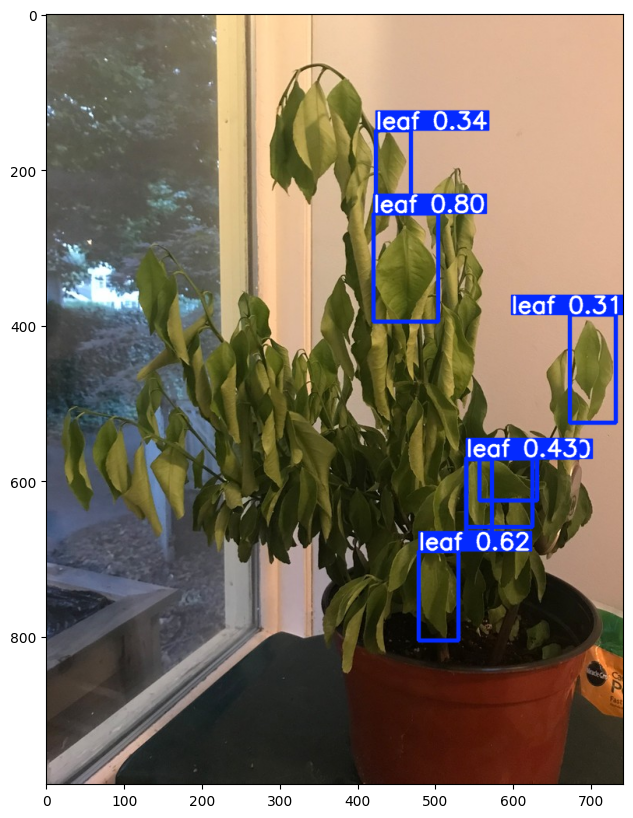

In [202]:
# run yolo model
results = yolo_model.predict(image_path, conf=confidence, verbose=False)

fig=plt.figure(figsize=(10, 10))
imshow = plt.imshow(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))

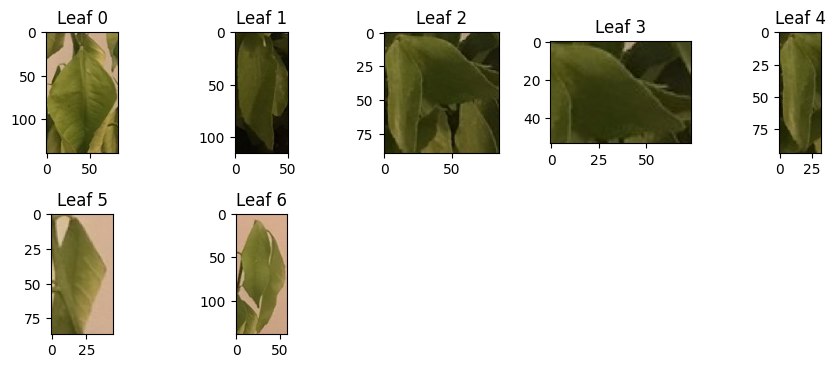

In [203]:
# set up matplotlib
fig=plt.figure(figsize=(9, 9))

# iterate over boxes
img = cv2.imread(image_path)
for i, box in enumerate(results[0].boxes.xyxy):
    # convert to PIL image
    x1, y1, x2, y2 = map(int, box[:4])
    cropped_image = img[y1:y2, x1:x2]
    pilimg = PIL.Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
    
    # add to matplotlib
    if(i < (fig_size*fig_size)):
        ax=fig.add_subplot(fig_size,fig_size,i+1)
        ax.imshow(pilimg)
        ax.set_title(f'Leaf {i}')
    
    # transform and unsqueeze for model input
    readyimg = test_transform(pilimg)
    readyimg = readyimg.unsqueeze(0)
    
    readyimg = readyimg.to(device)
    with torch.no_grad():
        efficientnet_model.eval()
        outputs = efficientnet_model(readyimg)
        
    # save results
    preds.append(outputs.data)
    
plt.tight_layout()

In [204]:
whole_image = [0] * 9
for i, pred in enumerate(preds):
    max_prediction = torch.max(pred, 1)
    whole_image[max_prediction.indices] = whole_image[max_prediction.indices] + 1;
    print("-" * 42)
    print(f"Leaf {i}:")
    for j in range(class_num):
        print("{:<20} {:>20.3f}".format(class_names[j], pred[0][j]))
    print("{:<20} {:>20}".format('MAX OUTPUT ARGUMENT', class_names[max_prediction.indices]))
print("-" * 42)
print("Whole image: ")
for i in range(class_num):
    print("{:<20} {:>20.1f}%".format(class_names[i], whole_image[i]/len(preds)*100))

------------------------------------------
Leaf 0:
Anthracnose                       -10.212
Bacterial Blight                   -5.254
Citrus Canker                       1.581
Curl Virus                         -5.809
Deficiency Leaf                     2.506
Dry Leaf                            5.997
Healthy Leaf                        5.983
Sooty Mould                         8.146
Spider Mites                       -2.774
MAX OUTPUT ARGUMENT           Sooty Mould
------------------------------------------
Leaf 1:
Anthracnose                         2.391
Bacterial Blight                   -3.789
Citrus Canker                      -0.756
Curl Virus                          1.248
Deficiency Leaf                     1.291
Dry Leaf                           -1.113
Healthy Leaf                        6.195
Sooty Mould                        -3.880
Spider Mites                       -2.187
MAX OUTPUT ARGUMENT          Healthy Leaf
------------------------------------------
Leaf 2:
Anthrac